In [219]:
import pandas as pd
from datetime import datetime
import csv
from matplotlib import pyplot as plt
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from nltk.corpus import stopwords
import string
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk
import re
from spellchecker import SpellChecker
import spacy
import seaborn as sns

In [220]:
pd.set_option("display.max_columns", None)
submission_df = pd.read_csv('submissions.csv')
submission_df.head()

,id,kind,category,created_utc,author,name,subreddit_id,subreddit_subscriber,subreddit,title,selftext,upvote_ratio,url,num_comments,ups,downs,total_awards_received,score,created,num_crossposts
0,slzdzs,t3,NaN,1.644162e+09,Independent_Bee_4468,t3_slzdzs,t5_2qs0k,51514,Home,What is this mud-like lump that recently appea...,NaN,0.50,https://www.reddit.com/gallery/slzdzs,28,0,0,0,0,1.644162e+09,0
1,qrti73,t3,NaN,1.636660e+09,TopSpite9394,t3_qrti73,t5_2qs0k,51514,Home,Any idea what this is? Sorry if this is a dumb...,NaN,0.60,https://www.reddit.com/gallery/qrti73,24,15,0,0,15,1.636660e+09,0
2,p1se4g,t3,NaN,1.628612e+09,villanegg,t3_p1se4g,t5_2qs0k,51514,Home,I just bought my first flat. First pic!,NaN,0.53,https://i.redd.it/ygtww9pv1kg71.jpg,6,1,0,0,1,1.628612e+09,0
3,oeiaps,t3,NaN,1.625525e+09,Cristheideaman,t3_oeiaps,t5_2qs0k,51514,Home,Exterior project my family completed follow on...,NaN,0.50,https://v.redd.it/sd1smhg84h971,0,0,0,0,0,1.625525e+09,0
4,nadi4r,t3,NaN,1.620784e+09,Nahughes121989,t3_nadi4r,t5_2qs0k,51514,Home,Loving my new living room setup. Just need a p...,NaN,0.59,https://i.redd.it/gt880tx8hly61.jpg,11,6,0,0,6,1.620784e+09,0


In [221]:
submission_df = submission_df.dropna(subset=['title'])
submission_df['selftext'].fillna(" ", inplace=True)
submission_df['transcript'] = submission_df['title'] + submission_df['selftext'] 
# group_submission = submission_df[['subreddit', 'transcript']].groupby('subreddit')
# submission_corpus = group_submission['transcript'].apply(lambda txt: " ".join(txt)).reset_index()
submission_df = submission_df.loc[:, ['subreddit', 'transcript']]
submission_df.head()

,subreddit,transcript
0,Home,What is this mud-like lump that recently appea...
1,Home,Any idea what this is? Sorry if this is a dumb...
2,Home,I just bought my first flat. First pic!
3,Home,Exterior project my family completed follow on...
4,Home,Loving my new living room setup. Just need a p...


In [222]:
comments_df = pd.read_csv('comments_.csv')
comments_df.head()

,author,body,created_utc,id,parent_id,subreddit,subreddit_id,score
0,LT-COL-Obvious,"Don’t shoot a BB gun at it, you’ll shoot your ...",1642012439,hsdpqpx,t3_s29o71,Home,t5_2qs0k,1
1,turkeyburpin,"1. Others are correct, check into your insulat...",1642011979,hsdohyq,t3_s29o71,Home,t5_2qs0k,1
2,c0ncept,These ripped an entire gutter off my old house...,1642011771,hsdnxhb,t3_s29o71,Home,t5_2qs0k,1
3,Jared944,Glue. Lots of glue. Glue it tight; glue it right.,1642011753,hsdnvrn,t3_s1uyss,Home,t5_2qs0k,1
4,PirateINDUSTRY,Nothing like doing sub-zero roofing work on yo...,1642010983,hsdlsv2,t1_hsdcpvs,Home,t5_2qs0k,1


In [223]:
comments_df = comments_df.dropna(subset=['body'])
# group_comments = comments_df[['subreddit', 'body']].groupby('subreddit')
# comment_corpus = group_comments['body'].apply(lambda txt: " ".join(txt)).reset_index()
comments_df = comments_df.rename(columns={'body': 'transcript'})
comments_df = comments_df.loc[:, ['subreddit', 'transcript']]
comments_df.head()

,subreddit,transcript
0,Home,"Don’t shoot a BB gun at it, you’ll shoot your ..."
1,Home,"1. Others are correct, check into your insulat..."
2,Home,These ripped an entire gutter off my old house...
3,Home,Glue. Lots of glue. Glue it tight; glue it right.
4,Home,Nothing like doing sub-zero roofing work on yo...


## Text Processing
When coming across Topic Modeling, we want to undergo these preprocessing steps to ensure quality context as input. Text corpus depends on the application domain, so it should be contextualised since the window of context will determine what words are considered to be related. Following are the main processes that can improve the results of topic modeling.
- <b>Data Cleansing</b> - Perform basic cleaning such as remove string special characters(punctuations/URls/HTML/emojis), lower casing and tokenization.
- <b>Frequency Filter</b> - Remove any words that occur too rarely over all the subreddits. The EDA of words and their frequency will gives us a sense on deciding the frequency value to be considered as a threshold.
- <b>Bigrams/Trigrams Architecture</b> - Build and evaluate unigram,bigram and trigram model. 
- <b>Stopwords, Lemmatization, Part of Speech Tagging</b> - Remove stopwords, lemmatize with POS tagging.

#### Concatenate both submissions and comments transcript

In [224]:
frames = [submission_df, comments_df]
corpus = pd.concat(frames).rename(columns={'transcript':'full_transcript'})
corpus.head()

,subreddit,full_transcript
0,Home,What is this mud-like lump that recently appea...
1,Home,Any idea what this is? Sorry if this is a dumb...
2,Home,I just bought my first flat. First pic!
3,Home,Exterior project my family completed follow on...
4,Home,Loving my new living room setup. Just need a p...


#### Data Cleaning - Lower casing & Remove string special characters

In [225]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

def remove_urls(text):
    pattern = re.compile(r'https?://\S+|www\.\S+')
    return pattern.sub('r', text)

def remove_html(text):
    pattern = re.compile(r'<.*?>')
    return pattern.sub('r', text)

In [226]:
lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
STOPWORDS = set(stopwords.words('english'))
spell = SpellChecker()

def data_cleaning(txt):
    txt = txt.lower() # Lower case
    txt = txt.translate(str.maketrans('', '', string.punctuation)) # Remove punctuations
    txt = remove_emoji(txt) # Remove emojis
    txt = remove_urls(txt) # Remove URLs
    txt = remove_html(txt) # Remove HTML
#     txt = " ".join([word for word in txt.split() if word not in STOPWORDS]) # Remove stopwords
#     pos_tagged_text = nltk.pos_tag(txt.split())
#     txt = " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text]) # Lemmatization
    return txt
    
cleaned_corpus = corpus
cleaned_corpus['full_transcript'] = cleaned_corpus["full_transcript"].apply(lambda x: data_cleaning(x))
cleaned_corpus.head()

,subreddit,full_transcript
0,Home,what is this mudlike lump that recently appear...
1,Home,any idea what this is sorry if this is a dumb ...
2,Home,i just bought my first flat first pic
3,Home,exterior project my family completed follow on...
4,Home,loving my new living room setup just need a pi...


In [227]:
cleaned_corpus.to_csv('cleaned_corpus.csv', index=False)

#### Minimum word count

In [228]:
cleaned_corpus['wordcount'] = cleaned_corpus["full_transcript"].apply(lambda x: len(x.split()))
cleaned_corpus.head()

,subreddit,full_transcript,wordcount
0,Home,what is this mudlike lump that recently appear...,17
1,Home,any idea what this is sorry if this is a dumb ...,37
2,Home,i just bought my first flat first pic,8
3,Home,exterior project my family completed follow on...,9
4,Home,loving my new living room setup just need a pi...,19


In [229]:
cleaned_corpus = cleaned_corpus[cleaned_corpus.wordcount > 0]
cleaned_corpus = cleaned_corpus.sort_values(by=['wordcount'])
cleaned_corpus = cleaned_corpus.drop_duplicates(subset=['full_transcript'], keep=False)
cleaned_corpus.head()

,subreddit,full_transcript,wordcount
30685,relationship_advice,updateme,1
12824,movies,ralphs,1
13000,movies,clifford,1
30574,discordapp,sniff,1
30543,discordapp,proof,1


In [230]:
cleaned_corpus[cleaned_corpus.wordcount == 2].head()

,subreddit,full_transcript,wordcount
7353,TrueOffMyChest,what field,2
18783,explainlikeimfive,found ground,2
18774,explainlikeimfive,nice point,2
7294,TrueOffMyChest,i pologize,2
10306,memes,go on,2


In [231]:
cleaned_corpus[cleaned_corpus.wordcount == 3].head()

,subreddit,full_transcript,wordcount
39806,nfl,palpatine do it,3
45049,olympics,lmao and happycakeday,3
34005,BestofRedditorUpdates,wow that’s something,3
34804,ProgrammerHumor,kannste nix ändern,3
34811,ProgrammerHumor,take my kruppvote,3


In [232]:
cleaned_corpus[cleaned_corpus.wordcount == 4].head()

,subreddit,full_transcript,wordcount
44315,pokemon,youre a good person,4
2532,interestingasfuck,thats metal as fuck,4
44397,pokemon,arsenal fans are summoned,4
2662,gifs,that’s a bigass dog,4
2659,gifs,that was pretty good,4


We want to ensure each document is meaningful to the topic modeling. Based on the observation above, minimum word count of each document is set to 3, because transcipt with 2 or less word count doesn't provide any useful features to the document.

In [233]:
# Minimum word count
min_wc = 3 
cleaned_corpus = cleaned_corpus[cleaned_corpus.wordcount >= min_wc]

#### Frequency Filter

In [234]:
from collections import Counter

# flat_list = []
# for sublist in data_words_bigrams:
#     for item in sublist:
#         flat_list.append(item)

cnt = Counter()
for text in cleaned_corpus.full_transcript.values:
    for word in text.split():
        cnt[word] += 1

common_df = pd.DataFrame()
common_df["word"] = [w for (w, wc) in cnt.most_common()]
common_df["frequency"] = [wc for (w, wc) in cnt.most_common()]
common_df.head()

,word,frequency
0,the,51823
1,to,36314
2,a,33048
3,and,29482
4,i,26513


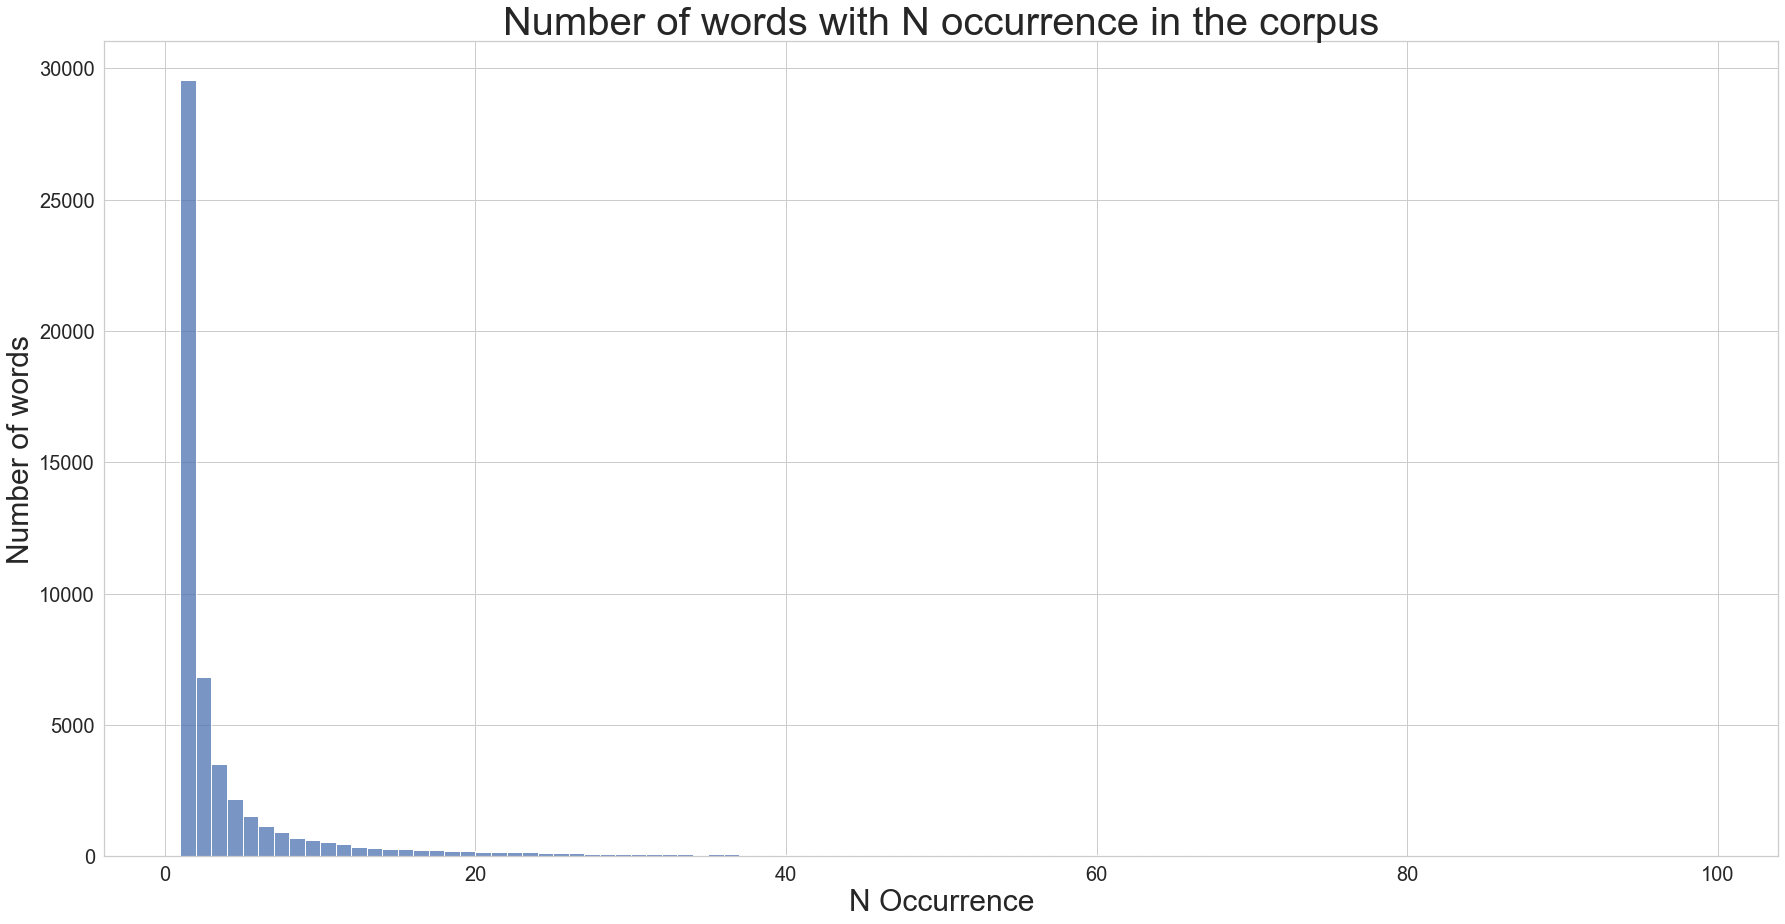

In [235]:
common_100_df = common_df[common_df.frequency < 100]

plt.rcParams['figure.figsize'] = [30, 15]
sns.set_theme(style="whitegrid")
h = sns.histplot(common_100_df, x="frequency", binwidth=1)
h.axes.set_title("Number of words with N occurrence in the corpus",fontsize=40)
h.set_xlabel("N Occurrence",fontsize=30)
h.set_ylabel("Number of words",fontsize=30)
h.tick_params(labelsize=20, axis='x')
h.tick_params(labelsize=20, axis='y')
plt.show()

Visualize the top 100 words frequency and we'll notice a right skew distribution. The threshold of frequency is set to be 1 as there's a huge gap of around 25000 for the number of words which occured only 1 times and remaining words. These rare and unique words which appear less likely in the corpus should be removed since these are essentially the weak features of the corpus. <b>Threshold ~ 1</b>

In [236]:
common_first_df = common_df[common_df.frequency == 1]
common_first_df.head()

,word,frequency
25340,happycakeday,1
25341,kannste,1
25342,ändern,1
25343,kruppvote,1
25344,azkaban,1


It's obvious that these rare words is mostly <b>due to spelling error</b>. So should we correct these spelling error using natural language tools? In this case, I would be more cautious about the usage of words in each documents, therefore I decide to remove these words instead of correcting all the spelling, since the nlp tools might classify the semantic meaning of each word incorrectly that form along with sentences. 

In [237]:
# Threshold is set as 1
N = 1
add_stop_words = [word for word, count in cnt.most_common() if count <= N]
print("Number of extra stopwords: ", len(add_stop_words))

Number of extra stopwords:  29562


In [238]:
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(add_stop_words)

####  Bigrams & Trigrams Architecture
Perform word tokenization, stopwords removal, make bigrams/trigrams and lemmatization and evaluate the result.

In [239]:
import gensim
from gensim.utils import simple_preprocess
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data = cleaned_corpus.full_transcript.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1][0][:30])

['palpatine', 'do', 'it']


In [240]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [241]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [242]:
data_words_nostops = remove_stopwords(data_words)
data_words_bigrams = make_bigrams(data_words_nostops)

#### Lemmatization by fine tuning the POS tag.
It's important to identify the suitable POS tag associated to our desire topics and eventually I decide to used the model that react to nouns and adjectives.
- Nouns, Adjectives, Verb, Adverb
- Nouns, Adjectives
- Nouns

<b>PS. All the decision made below on fine tuning the POS tag are based on multiple failed attempt on extracting important topics from LDA model. Hence, I've create another notebook for these failed attempts and clarify the findings here: https://github.com/leslieyuandev/.</b>

In [243]:
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
nlp.max_length = 1400000

# Do lemmatization keeping noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VB', 'ADV'])
data_lemmatized_NA = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ'])
data_lemmatized_N = lemmatization(data_words_bigrams, allowed_postags=['NOUN'])
print(data_lemmatized_NA[:1])

[['palpatine']]


In [244]:
import pickle

file_name = "data_preprocessed"
open_file = open(file_name, "wb")
pickle.dump(data_lemmatized_NA, open_file)
open_file.close()